In [154]:
import pandas
import datetime
import torch
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

# https://mipais.jmarcano.com/geografia/geografia-nacional/division/region_este/#:~:text=La%20Regi%C3%B3n%20Este%20incluye%20las,Domingo%20y%20el%20Distrito%20Nacional.
# https://mipais.jmarcano.com/varios/iso3166/
provinces_cod = [8, 30, 11, 12, 29, 23, 32, 1]
min_date = '2020-03-01'
max_date = '2021-03-01'

provinces = pandas.read_csv('data/provincias.csv', parse_dates=['fecha'])
provinces = provinces[['fecha', 'Prov_Cod', 'Muestras_Acumulados', 'Confirmados_AcumuladosFTM', 'Defunciones_Acumulados', 'Recuperados_Acumulados']]
provinces = provinces[provinces.Prov_Cod.isin(provinces_cod)]
provinces = provinces[provinces['fecha'] >= min_date]
provinces = provinces[provinces['fecha'] < max_date]
provinces

,fecha,Prov_Cod,Muestras_Acumulados,Confirmados_AcumuladosFTM,Defunciones_Acumulados,Recuperados_Acumulados
60,2020-03-01 00:00:00+00:00,1,2,0,0,2
61,2020-03-02 00:00:00+00:00,1,2,0,0,2
62,2020-03-03 00:00:00+00:00,1,2,0,0,2
63,2020-03-04 00:00:00+00:00,1,4,1,0,2
64,2020-03-05 00:00:00+00:00,1,6,1,0,2
...,...,...,...,...,...,...
13874,2021-02-24 00:00:00+00:00,32,226467,49760,609,41052
13875,2021-02-25 00:00:00+00:00,32,227414,49866,610,41405
13876,2021-02-26 00:00:00+00:00,32,228408,50003,610,41751
13877,2021-02-27 00:00:00+00:00,32,228724,50050,610,41949


In [155]:
totals = provinces.groupby('fecha').agg(
    total_cases=pandas.NamedAgg(column='Confirmados_AcumuladosFTM', aggfunc=sum),
    total_deaths=pandas.NamedAgg(column='Defunciones_Acumulados', aggfunc=sum),
    total_tests=pandas.NamedAgg(column='Muestras_Acumulados', aggfunc=sum),
    total_recovered=pandas.NamedAgg(column='Recuperados_Acumulados', aggfunc=sum),
)
totals

,total_cases,total_deaths,total_tests,total_recovered
fecha,,,,
2020-03-01 00:00:00+00:00,0,1,3,2
2020-03-02 00:00:00+00:00,0,1,3,2
2020-03-03 00:00:00+00:00,0,1,5,2
2020-03-04 00:00:00+00:00,4,1,14,2
2020-03-05 00:00:00+00:00,4,1,21,2
...,...,...,...,...
2021-02-24 00:00:00+00:00,137796,1436,712715,112381
2021-02-25 00:00:00+00:00,138119,1438,715782,113362
2021-02-26 00:00:00+00:00,138455,1439,718540,114289


Text(0.5, 1.0, 'gente que guindaron lo teni con covi:')

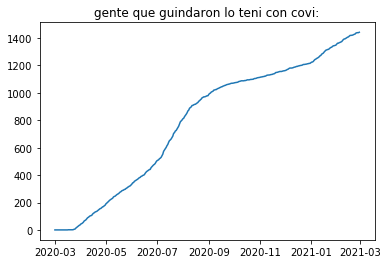

In [156]:
plt.plot(totals['total_deaths'])
plt.title("gente que guindaron lo teni con covi:")

In [157]:
totals['total_deaths'].shape

(365,)

Text(0.5, 1.0, 'gente que le dio covi:')

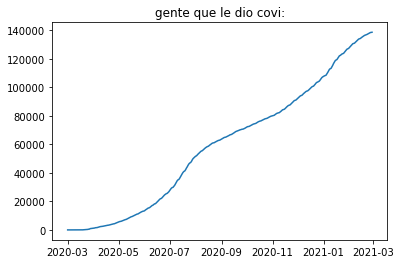

In [158]:
plt.plot(totals['total_cases'])
plt.title("gente que le dio covi:")

In [159]:
# Train-Test split and Scaling

In [160]:
totals['total_cases'].shape

(365,)

In [161]:
test_data_size = 51
daily_deaths = totals['total_deaths']


train_data = daily_deaths[:-test_data_size]
test_data = daily_deaths[-test_data_size:]
train_data.shape

(314,)

In [162]:
# We use scaling to speed up training process
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [163]:
# Creates sequences of fixed lengths
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [164]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [165]:
X_train.shape

torch.Size([308, 5, 1])

In [166]:
X_train[:2]

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.]]])

In [167]:
y_train.shape

torch.Size([308, 1])

In [168]:
y_train[:2]

tensor([[0.],
        [0.]])

In [169]:
train_data[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [170]:
class CoronaVirusPredictor(nn.Module):
  def __init__(self,n_features,n_hidden,seq_len,n_layers=2):
    super(CoronaVirusPredictor,self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    # A set of LSTM layers followed by a Dense/Linear layer that intakes the 
    # final time step from the final LSTM layer
    self.lstm = nn.LSTM(
        input_size=n_features,
        hidden_size=n_hidden,
        num_layers = n_layers,
        dropout=0.5

    )

    self.linear = nn.Linear(in_features=n_hidden,out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers,self.seq_len,self.n_hidden),
        torch.zeros(self.n_layers,self.seq_len,self.n_hidden)
    )

  def forward(self,sequences):
    lstm_out,self.hidden = self.lstm(
        sequences.view(len(sequences),self.seq_len,-1),
        self.hidden
    )

    last_time_step = lstm_out.view(self.seq_len,len(sequences),self.n_hidden)[-1]

    y_pred = self.linear(last_time_step)
    return y_pred


In [171]:
def train_model(model,epochs,train_data,train_labels,test_data=None,test_labels=None):
  
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters(),lr=1e-3)
  epochs=epochs

  train_hist = np.zeros(epochs)
  test_hist = np.zeros(epochs)

  for t in range(epochs):
    # reset hidden state since we're using stateless LSTMs
    model.reset_hidden_state()

    y_pred = model(train_data)

    loss = loss_fn(y_pred.float(),train_labels)


    if test_data is not None:
      #turn off gradient for test/validation prediction
      with torch.no_grad():
        
        y_test_pred = model(test_data)
        test_loss = loss_fn(y_test_pred.float(),test_labels)
      test_hist[t] = test_loss.item()

      if t%10==0:
        print(f'Epoch {t} train loss : {loss.item()} test loss : {test_loss.item()}')

    elif t%10==0:
      print(f'Epoch {t} train loss {loss.item()}')


    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(),train_hist,test_hist


In [172]:
model = CoronaVirusPredictor(
    n_features = 1,
    n_hidden=120,
    seq_len=seq_length,
    n_layers=3
    )

model, train_hist, test_hist = train_model(
  model = model,
  epochs=120,
  train_data = X_train,
  train_labels = y_train,
  test_data  = X_test,
  test_labels = y_test
)

# Best hyperparameters observed as of now
    # n_features = 1,
    # n_hidden=120,
    # seq_len=seq_length,
    # n_layers=3

Epoch 0 train loss : 122.9170913696289 test loss : 50.7379035949707
Epoch 10 train loss : 40.27152633666992 test loss : 8.404099464416504
Epoch 20 train loss : 36.820743560791016 test loss : 15.658367156982422
Epoch 30 train loss : 36.189334869384766 test loss : 11.885919570922852
Epoch 40 train loss : 36.54856872558594 test loss : 12.812003135681152
Epoch 50 train loss : 35.82094955444336 test loss : 12.381587028503418
Epoch 60 train loss : 36.58024215698242 test loss : 12.085864067077637
Epoch 70 train loss : 36.27827453613281 test loss : 12.074475288391113
Epoch 80 train loss : 36.03947067260742 test loss : 11.870692253112793
Epoch 90 train loss : 34.57040023803711 test loss : 10.885000228881836
Epoch 100 train loss : 30.793415069580078 test loss : 3.7588117122650146
Epoch 110 train loss : 36.05769348144531 test loss : 6.607443809509277


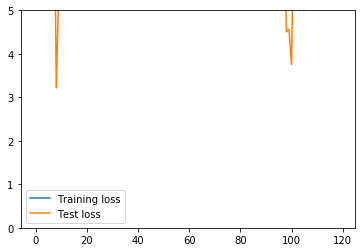

In [173]:
# Train vs Test loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [174]:
# Reusing the predicted values as input for next days
# as our model predicts only for the next single day

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [175]:
true_deaths = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_deaths = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


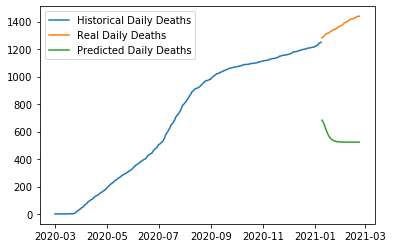

In [176]:
plt.plot(
  daily_deaths.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Deaths'
)

plt.plot(
  daily_deaths.index[len(train_data):len(train_data) + len(true_deaths)],
  true_deaths,
  label='Real Daily Deaths'
)

plt.plot(
  daily_deaths.index[len(train_data):len(train_data) + len(true_deaths)],
  predicted_deaths,
  label='Predicted Daily Deaths'
)

plt.legend();

In [177]:
# Repeating the same preprocessing but for entire data
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_deaths, axis=1))

all_data = scaler.transform(np.expand_dims(daily_deaths, axis=1))

all_data.shape

(365, 1)

In [178]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor.plot(daily_deaths, label='Historical Daily Death')
plt.plot(predicted_deaths, label='Predicted Daily Deaths')
plt.legend();tor(
  n_features=1,
  n_hidden=120,
  seq_len=seq_length,
  n_layers=3
)
model, train_hist, _ = train_model(model=model,epochs=120,train_data=X_all, train_labels=y_all)

AttributeError: type object 'CoronaVirusPredictor' has no attribute 'plot'

In [ ]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
predicted_deaths = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
daily_deaths.index[-1]

In [ ]:
predicted_index = pd.date_range(
  start=daily_deaths.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_deaths = pd.Series(
  data=predicted_deaths,
  index=predicted_index
)

plt.plot(predicted_deaths, label='Predicted Daily Deaths')
plt.legend();

In [ ]:
plt.plot(daily_deaths, label='Historical Daily Death')
plt.plot(predicted_deaths, label='Predicted Daily Deaths')
plt.legend();